In [105]:
#import the required libraries
from IPython.display import HTML
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [106]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('submission.csv')
train = pd.read_csv('train.csv')

In [60]:
train["HomePlanet"].value_counts()

Earth     4634
Europa    2161
Mars      1787
Name: HomePlanet, dtype: int64

In [66]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Expenses
Age,1.000000,0.069110,0.129694,0.033169,0.123685,0.100926,-0.075026,0.186530
RoomService,0.069110,1.000000,-0.014295,0.056238,0.011483,-0.018171,-0.244925,0.239020
FoodCourt,0.129694,-0.014295,1.000000,-0.012615,0.222834,0.228902,0.044595,0.745248
ShoppingMall,0.033169,0.056238,-0.012615,1.000000,0.015357,-0.005958,0.007966,0.223531
Spa,0.123685,0.011483,0.222834,0.015357,1.000000,0.154754,-0.221592,0.596932
VRDeck,0.100926,-0.018171,0.228902,-0.005958,0.154754,1.000000,-0.207630,0.586578
Transported,-0.075026,-0.244925,0.044595,0.007966,-0.221592,-0.207630,1.000000,-0.199514
Expenses,0.186530,0.239020,0.745248,0.223531,0.596932,0.586578,-0.199514,1.000000


PassengerId        0
HomePlanet       111
CryoSleep        119
Cabin             99
Destination      103
Age              179
VIP              116
RoomService      113
FoodCourt        113
ShoppingMall     112
Spa              118
VRDeck           126
Name               0
Transported        0
Expenses           0
Room               0
Cabin_y           99
VIP_y            116
HomePlanet_y     111
Destination_y    103
Cabin_1           99
Cabin_3           99
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   HomePlanet     8582 non-null   object 
 2   CryoSleep      8574 non-null   object 
 3   Cabin          8594 non-null   object 
 4   Destination    8590 non-null   object 
 5   Age            8514 non-null   float64
 6   VIP            8577 non-null   object 
 7   RoomService    85

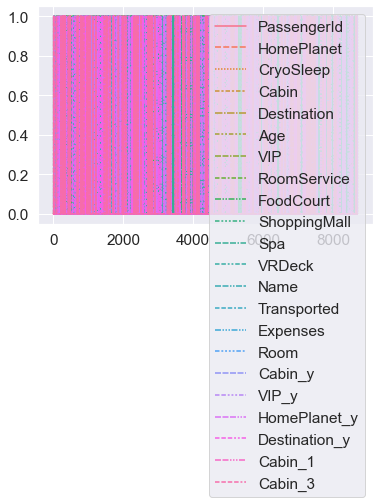

In [42]:
print(train.isnull().sum())
sns.lineplot(data=train.isnull())
print(train.info())

PassengerId       0
HomePlanet       46
CryoSleep        55
Cabin            63
Destination      51
Age              91
VIP              56
RoomService      57
FoodCourt        67
ShoppingMall     63
Spa              59
VRDeck           51
Name              0
Expenses          0
Room              0
Cabin_y          63
VIP_y            56
HomePlanet_y     46
Destination_y    51
Cabin_1          63
Cabin_3          63
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 8693 to 12969
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4231 non-null   object 
 2   CryoSleep      4222 non-null   object 
 3   Cabin          4214 non-null   object 
 4   Destination    4226 non-null   object 
 5   Age            4186 non-null   float64
 6   VIP            4221 non-null   object 
 7   RoomService    4220 non-null   float64
 8   FoodCourt  

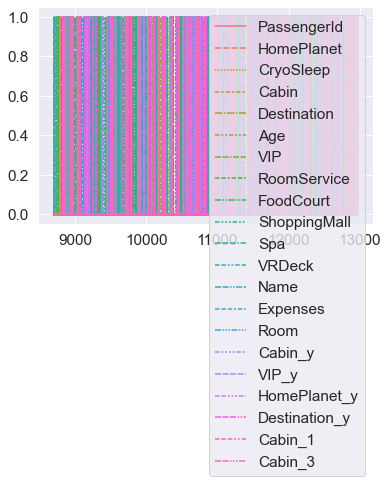

In [43]:
print(test.isnull().sum())
sns.lineplot(data=test.isnull())
print(test.info())

In [8]:
#Preprocessing
#All of the travelers were from the same ship. This eliminates the need for us to independently look for lost information.
train_test=train.append(test)

PassengerId         0
HomePlanet        157
CryoSleep         174
Cabin             162
Destination       154
Age               270
VIP               172
RoomService       170
FoodCourt         180
ShoppingMall      175
Spa               177
VRDeck            177
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
Cabin_1           162
Cabin_3           162
dtype: int64


<AxesSubplot:>

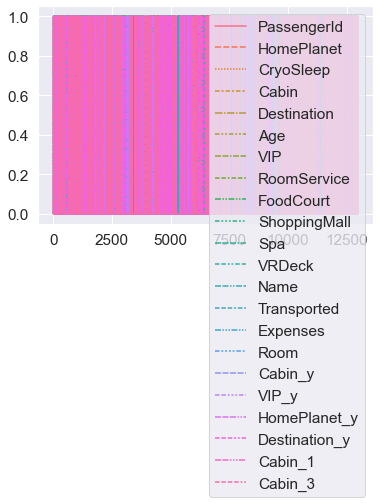

In [44]:
print(train_test.isnull().sum())
sns.lineplot(data=train_test.isnull())

In [45]:
Exp_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [46]:
#If a passenger was in CryoSleep, let's replace the missing fee with "0". You don't spend money if you're sleeping.
train_test.loc[:,Exp_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [12]:
#We can infer from the description of the contest rules that someone who is in cryosleep is unable to pay for extra services. Additionally, we should keep in mind this aspect of cryosleep when filling in the blanks in the columns marked "Age, Room Service, Food Court, ShoppingMall, Spa, VRDec'k". Based on this conclusion, let's fill in the blanks.
train_test['Expenses'] = train_test.iloc[:,7:12].sum(axis=1)

In [13]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses ==0 and pd.isna(x.CryoSleep) else x,axis =1)

In [14]:
#I don't know if we can get back some of the Names information. In order to avoid having to split the column in the future, let's fill in this column with "Unknown Unknown."
train_test.Name = train_test.Name.fillna('Unknown Unknown')

In [15]:
train_test.loc[:,['Room']] = train_test.PassengerId.apply(lambda x: x[0:4] )
#Here, I wish to build manuals where information about the cabin, VIP status, home planet, and destination can be filled up.
guide_VIP=train_test.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=train_test.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=train_test.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=train_test.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
train_test=pd.merge(train_test,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_VIP,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [16]:
train_test.loc[:,['VIP']]=train_test.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['Destination']]=train_test.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [17]:
train_test[train_test.Cabin.isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,908.0,0012,NaN,False,Earth,TRAPPIST-1e
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,0.0,0101,NaN,False,Mars,TRAPPIST-1e
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,Diedow Resty,False,1048.0,0239,NaN,False,Mars,TRAPPIST-1e
272,0301_01,Earth,True,NaN,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Margia Wriggins,False,0.0,0301,NaN,False,Earth,TRAPPIST-1e
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,4476.0,241.0,Naviton Coudered,False,4947.0,0310,NaN,False,Europa,TRAPPIST-1e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,9058_01,Mars,False,NaN,TRAPPIST-1e,38.0,NaN,784.0,0.0,42.0,38.0,10.0,Hammet Muff,NaN,874.0,9058,NaN,NaN,Mars,TRAPPIST-1e
12902,9138_01,Europa,NaN,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,Misamak Trupistic,NaN,3888.0,9138,NaN,False,Europa,TRAPPIST-1e
12941,9223_01,Mars,True,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Weessh Sun,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e
12942,9223_02,Mars,True,NaN,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,Perit Sun,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e


PassengerId         0
HomePlanet        157
CryoSleep         174
Cabin             162
Destination       154
Age               270
VIP               172
RoomService       170
FoodCourt         179
ShoppingMall      172
Spa               173
VRDeck            172
Name                0
Transported      4277
Expenses            0
Room                0
Cabin_y           162
VIP_y             172
HomePlanet_y      157
Destination_y     154
Cabin_1           162
Cabin_3           162
dtype: int64


<AxesSubplot:>

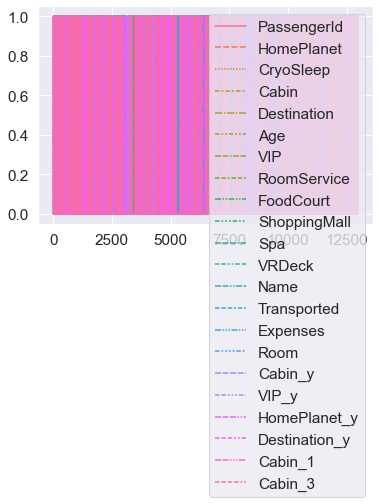

In [47]:
pd.set_option('display.max_rows', 100)
print(train_test.isnull().sum())
sns.lineplot(data=train_test.isnull())

In [19]:
#Split the column and remove any unnecessary columns.
train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]
train_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y,Cabin_1,Cabin_3
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0.0,0001,B/0/P,False,Europa,TRAPPIST-1e,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,736.0,0002,F/0/S,False,Earth,TRAPPIST-1e,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,10383.0,0003,A/0/S,True,Europa,TRAPPIST-1e,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,5176.0,0003,A/0/S,True,Europa,TRAPPIST-1e,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,1091.0,0004,F/1/S,False,Earth,TRAPPIST-1e,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,Jeron Peter,NaN,0.0,9266,F/1796/S,False,Earth,TRAPPIST-1e,G,S
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,...,Matty Scheron,NaN,1018.0,9269,NaN,False,Earth,TRAPPIST-1e,NaN,None
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,...,Jayrin Pore,NaN,0.0,9271,D/296/P,False,Mars,55 Cancri e,D,P
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,...,Kitakan Conale,NaN,3203.0,9273,D/297/P,False,Europa,NaN,D,P


In [100]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore')

num_transformer = Pipeline(steps=[('impute', num_imp)])

cat_transformer = Pipeline(steps=[
    ('impute', cat_imp),
    ('onehot', ohe)])

num_cols = ['Age','Expenses','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_cols = ['HomePlanet','CryoSleep','VIP','Cabin_3','Cabin_1']

pre_processor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cut', cat_transformer, cat_cols)])

In [21]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('bool')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [22]:
X=train.drop('Transported',axis=1)
y = train.Transported

In [101]:
#RandomForestClassifier
model_RFC=RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)
my_pipeline_RFC = Pipeline (steps=[
    ('pre_processor',pre_processor),
    ('model',model_RFC)])

print(cross_val_score(my_pipeline_RFC,X,y,cv=5,scoring='accuracy').mean())

0.7994966222006351


In [102]:
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
Decision_TreeModel = DecisionTreeClassifier()
Decision_TreePipeLine = Pipeline (steps=[
('pre_processor',pre_processor),
('model',Decision_TreeModel)])
print(cross_val_score(Decision_TreePipeLine, X, y,cv = 5, scoring = 'accuracy').mean())

0.7479594571434054


In [103]:
#KNeighborsClassifier.
model_KNC = KNeighborsClassifier(n_neighbors=40)
my_pipeline_KNC = Pipeline (steps=[
    ('pre_processor',pre_processor),
    ('model',model_KNC)])
print(cross_val_score(my_pipeline_KNC,X,y,cv=5,scoring='accuracy').mean())

0.7892574796964779


In [104]:
#XGBClassifier
model_XGBC = XGBClassifier(n_estimators=100, learning_rate = 0.13, n_jobs=4)
my_pipeline_XGBC = Pipeline (steps=[
('pre_processor',pre_processor),
('model',model_XGBC)])
print(cross_val_score(my_pipeline_XGBC, X, y,cv = 5, scoring = 'accuracy').mean())

0.8027167313728046


In [28]:
my_pipeline_XGBC.fit(X,y)
prediction = my_pipeline_XGBC.predict(test)
output = pd.DataFrame({'PassengerId': test.PassengerId,
                       'Transported': prediction})
output['Transported']=output['Transported'].astype('bool')
output.to_csv('submission_1.csv', index=False)